In [10]:
import pandas as pd
import numpy as np
rng = np.random.default_rng()
from tqdm.notebook import tqdm
tqdm.pandas()
import math
import time
import matplotlib.pyplot as plt
%cd /home/jeroen/repos/traffic-scheduling/single
from automaton import Automaton, evaluate
from exact import solve

/home/jeroen/repos/traffic-scheduling/single


# Comparative analysis of computational efficiency

First, we analyze the efficiency of the branch-and-cut approach by measuring the average running time over different problem distributions. In particular, we are interested in which type of cutting planes provide the greatest average speed up. Second, we analyze the performance of the various heuristics based on their average optimality gap over some classes of problem instances.

## Instance generation functions

In [2]:
rho = 4
sigma = 1

There are several ways to characterize the distribution of problem instances, for example
- number of routes,
- number of arrivals per route,
- arrival intensity per route,
- symmetric or assymtric arrival intensities,
- degree of platooning.

A simple way of modeling the natural occurence of platoons in the arrival process is by using a bimodal distribution $F$ for the interarrival times. We will use a mixture of two exponential random variables with different means, representing the small gaps between vehicles in the same platoon and the large gaps between vehicles of different platoons.

In [3]:
def bimodal_exponential(p=0.3, s1=1, s2=10):
    def generate(n):
        ps = rng.binomial(1, p, size=(n))
        return ps * rng.exponential(scale=s1, size=(n)) + (1-ps) * rng.exponential(scale=s2, size=(n))
    return generate

Introduce some helper functions to generate instances.

In [4]:
def empty_instance():
    return { 'switch': sigma, 'release': [], 'length': [] }

def add_route(instance, releases, lengths):
    instance['release'].append(releases)
    instance['length'].append(lengths)

def cumulate(gaps):
    """Compute $A_n = A_{n-1} + X_n + \rho$ for all n, where X_n is given by `gaps`."""
    lengths = np.repeat(rho, len(gaps))
    shifted = np.roll(lengths, 1); shifted[0] = 0
    releases = np.cumsum(gaps + shifted)
    return releases, lengths

We start with simple symmetric instances, where each route has the same interarrival time distribution.

In [5]:
def generate_symmetric_instance(F, n_vehicles, n_routes=2):
    """F is a function to generate interarrival times."""
    instance = empty_instance()
    for _ in range(n_routes):
        gaps = F(n_vehicles)
        add_route(instance, *cumulate(gaps))
    return instance

Define some helper methods to compute the normalized objective (delay) for comparison across different instance sizes.

In [6]:
def instance_size(instance):
    return sum(len(rs) for rs in instance['release'])

In [7]:
def average_release(test):
    total = 0
    for instance in test['instance']:
        total += np.sum(instance['release'])
    return total / len(test['instance'])

## Measure branch-and-cut running time

We measure the average running time of the MILP-solver for different selections of cutting planes. To prevent running times blowing up, we use a fixed time-out for each instance. For this analysis, we do not keep track of the optimal schedule for comparison, we will do that somewhere else, with a larger time-out.

In [11]:
from itertools import combinations
from math import isclose

def measure_exact(instances, cuts=None, timelimit=20, with_done=True):
    data = pd.DataFrame(zip(instances), columns=['instance'])
    
    def solve_instance(row, cuts):
        start = time.time()
        res = solve(row['instance'], timelimit=timelimit, cutting_planes=cuts)
        return time.time() - start, res['done'], res['obj']

    cid = lambda cuts: ''.join(str(c) for c in cuts)
    for c in cuts:
        data[[f'running_time_{cid(c)}', f'done_{cid(c)}', f'obj_{cid(c)}']] = \
            data.progress_apply(lambda x: solve_instance(x, c), axis=1, result_type='expand')

    # little test to verify cutting planes: check if pairwise objectives match
    # for c1, c2 in combinations(cuts, 2):
    #     data['matching'] = data.apply(lambda x: isclose(x[f'obj_{cid(c1)}'], x[f'obj_{cid(c2)}'], abs_tol=1e-02), axis=1)
    #     assert data['matching'].all()
    
    data = data.drop(['instance', 'matching'], axis=1, errors='ignore')
    data = data.drop([f'obj_{cid(c)}' for c in cuts], axis=1)
    if not with_done:
        data = data.drop([f'done_{cid(c)}' for c in cuts], axis=1)
    return data

In [43]:
timelimit = 20

F = bimodal_exponential(p=0.5, s1=0.1, s2=10)
ns = [5, 10, 15, 20, 25, 30, 35, 40]
cuts = [[1], [2], [3]]
N = 10

from datetime import datetime, timedelta
bound = timedelta(seconds=len(ns) * len(cuts) * N * timelimit)
print(f"runtime upper bound: {bound}")

runtime upper bound: 1:20:00


Note that running times might become "censored" due to the use of a time limit. We need to deal with this in the generation of the plots.

In [44]:
started = datetime.now()
print(f"started: {started.strftime('%H:%M:%S')}")
end = started + bound
print(f"done before: {end.strftime('%H:%M:%S')}")

data = []
for n in ns:
    print(n)
    instances = [generate_symmetric_instance(F, n) for _ in range(N)]
    rows = measure_exact(instances, cuts=cuts, timelimit=timelimit, with_done=False)
    rows['n'] = n
    data.append(rows)

total = pd.concat(data, ignore_index=True).set_index('n').groupby('n').mean()
plt.plot(total)
plt.legend(['transitive', 'conjunctive', 'disjunctive'])
plt.xlabel('arrivals per route')
plt.ylabel('average running time in seconds')
plt.savefig(f'../report/data-comparison/running_times.pdf')
plt.close()

started: 13:51:56
done before: 15:11:56
5


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

10


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

15


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

20


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

25


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

30


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

35


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

40


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

## Threshold heuristic

In [8]:
def threshold_heuristic(automaton, tau=0):
    # default first lane is 0
    l = automaton.last_lane or 0
    # last scheduled vehicle
    k = automaton.k[l] - 1

    # next vehicle exists
    if k + 1 < automaton.K[l]:
        # earliest crossing time of next vehicle in lane
        r = automaton.instance['release'][l][k+1]

        if automaton.LB[l][k] + automaton.instance['length'][l][k] + tau >= r:
            return l

    # next lane with unscheduled vehicles
    l = (l + 1) % automaton.N
    while automaton.k[l] == automaton.K[l]:
        l = (l + 1) % automaton.N
    return l

We tune the threshold based on a set of training instances and measure the peformance on a test set.

In [21]:
taus = np.arange(0.1, 4.1, 0.05)
threshold_train_scores = []
threshold_train_times = {}

def train_threshold(train, set_id):
    # evaluate threshold heuristic on every instance to get average objective
    train_scores = np.empty((taus.shape[0]))
    start = time.time()
    for i, tau in enumerate(tqdm(taus, leave=False)):
        heuristic = lambda automaton: threshold_heuristic(automaton, tau=tau)
        res = train.apply(lambda x: evaluate(x['instance'], heuristic), axis=1)
        # store normalized train score
        train_scores[i] = (res.mean() - average_release(train)) / instance_size(train['instance'][0])

    threshold_train_times[set_id] = time.time() - start
    threshold_train_scores.append(train_scores)
    return taus[np.argmin(train_scores)]

def eval_threshold(train, test, set_id):
    tau_opt = train_threshold(train, set_id)
    heuristic = lambda automaton: threshold_heuristic(automaton, tau=tau_opt)
    return test.apply(lambda x: evaluate(x['instance'], heuristic), axis=1).mean()

## Neural heuristic

In [34]:
import torch
import torch.optim as optim
from torch.nn.functional import binary_cross_entropy_with_logits
from torch.utils.data import TensorDataset, DataLoader

We use the optimal solutions obtained in for the training data set to train the model by imitation learning.

In [44]:
neural_losses = []
neural_train_times = {}

def train_neural(train, model, set_id):
    start = time.time()

    # extracting (state, next_lane) pairs by replaying optimal lane ordering
    states, actions = [], []
    for _, row in tqdm(train.iterrows(), total=train.shape[0], leave=False):
        instance, eta = row[['instance', 'opt_eta']]
        eta = iter(eta)
        automaton = Automaton(instance)
        while not automaton.done:
            lane = next(eta)
            state = model.state_transform(automaton)
            action = model.inverse_action_transform(automaton, lane)
            automaton.step(lane)
            states.append(state)
            actions.append(action)
    
    epochs = 10
    batch_size = 10
    train_set = TensorDataset(torch.vstack(states), torch.vstack(actions))
    data_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    
    learning_rate = 1e-3
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    losses = []
    model.train()
    for i in range(epochs):
        for s, a in tqdm(data_loader, leave=False):
            optimizer.zero_grad()
            logit = model(s)
            loss = binary_cross_entropy_with_logits(logit, a)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

    neural_train_times[set_id] = time.time() - start
    neural_losses.append(losses)
    return model

In [40]:
from model import PaddedEmbeddingModel, RecurrentEmbeddingModel

def eval_neural(train, test, set_id, Model=RecurrentEmbeddingModel):
    lanes = len(train['instance'][0]['release'])
    max_veh = len(train['instance'][0]['release'][0])
    model = Model(lanes=lanes, max_horizon=max_veh).cuda()
    model = train_neural(train, model, set_id)    
    model.eval()
    trained_heuristic = lambda automaton: \
               model.action_transform(automaton, model(model.state_transform(automaton)))

    def eval(row):
        instance = row['instance']
        obj = evaluate(instance, trained_heuristic)
        return obj

    return test.progress_apply(eval, axis=1, result_type='expand').mean()

## Generate train and test sets

We define three different types of platoon occurence: large isolated platoons, frequent small platoons, very regular (almost no platoons).

In [12]:
# interarrival time distributions, with same arrival intensity using s2 = (mu - p*s1) / (1 - p)
Fs = [
    bimodal_exponential(p=0.5, s1=0.1, s2=10),
    bimodal_exponential(p=0.3, s1=0.1, s2=7.171428571428572),
    bimodal_exponential(p=0.1, s1=0.1, s2=5.6),
]

To give an idea of these arrival distributions, we plot some arrivals for a single route.

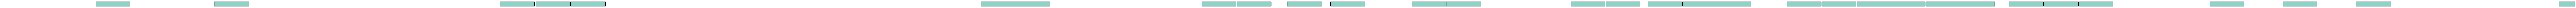

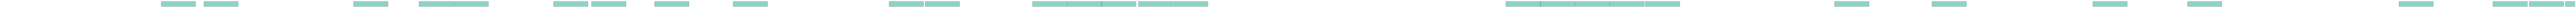

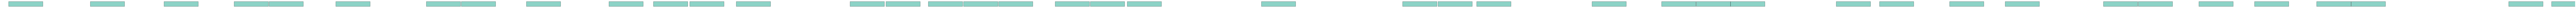

In [13]:
from util import plot_schedule
n_vehicles = 50
for F in Fs:
    instance = empty_instance()
    gaps = F(n_vehicles)
    add_route(instance, *cumulate(gaps))
    plot_schedule(instance, clean=True, custom_end_time=300)

Define a series of problem instance specifications.

In [26]:
data = pd.DataFrame([
    [0, 10], [0, 30], [0, 50],
    [1, 10], [1, 30], [1, 50],
    [2, 10], [2, 30], [2, 50],
])
data.columns = ['gen_id', 'n_vehicles']
data['set_name'] = data.apply(lambda row: ['low', 'med', 'high'][row['gen_id']], axis=1)
data.index.name = 'set_id'
data

,gen_id,n_vehicles,set_name
set_id,,,
0,0,10,low
1,0,30,low
2,0,50,low
3,1,10,med
4,1,30,med
5,1,50,med
6,2,10,high
7,2,30,high
8,2,50,high


For each specification, we generate some training instances and some test instances that will be used in the final optimality evaluation.

In [15]:
N_train, N_test = 10, 10
train, test = {}, {}
for i, row in data.iterrows():
    n = row['n_vehicles']
    f = lambda: generate_symmetric_instance(Fs[row['gen_id']], n)
    train[i] = pd.DataFrame(zip([f() for _ in range(N_train)]), columns=['instance'])
    test[i] = pd.DataFrame(zip([f() for _ in range(N_test)]), columns=['instance'])

## Compute optimal solutions

We use the best cutting plane selected in the previous section to compute the optimal solutions, where possible. Whenever it becomes too expensive to compute the optimal solution, we use the best solution obtained by MILP after a certain time limit. These optimal solutions are also used for the neural heuristic when imitation learning is employed.

In [16]:
from util import lane_order

timelimit_opt = 5

def solve_instance(x):
    res = solve(x['instance'], timelimit=timelimit_opt, cutting_planes=[2])
    return res['y'], res['obj']

for i, _ in data.iterrows():
    train[i][[f'opt_y', f'opt_obj',]] = train[i].progress_apply(solve_instance, axis=1, result_type='expand')
    test[i][[f'opt_y', f'opt_obj',]] = test[i].progress_apply(solve_instance, axis=1, result_type='expand')
    
    # compute optimal lane order for training instances (for imitation learning)
    train[i]['opt_eta'] = train[i].apply(lambda x: lane_order(x['opt_y']), axis=1)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

## Collect and report measurements

Run all the analyses at once, without any kind of checkpoints.

In [46]:
#data['threshold_obj'] = data.apply(lambda row: eval_threshold(train[row.name], test[row.name], row.name), axis=1)
#data['threshold_train_time'] = threshold_train_times

#data['neural_obj'] = data.apply(lambda row: eval_neural(train[row.name], test[row.name], row.name, Model=RecurrentEmbeddingModel), axis=1)
#data['neural_train_time'] = neural_train_times

data['opt_obj'] = data.apply(lambda row: test[row.name]['opt_obj'].mean(), axis=1)

### Threshold fit

Plot the train scores for the various thresholds to verify the model fit.

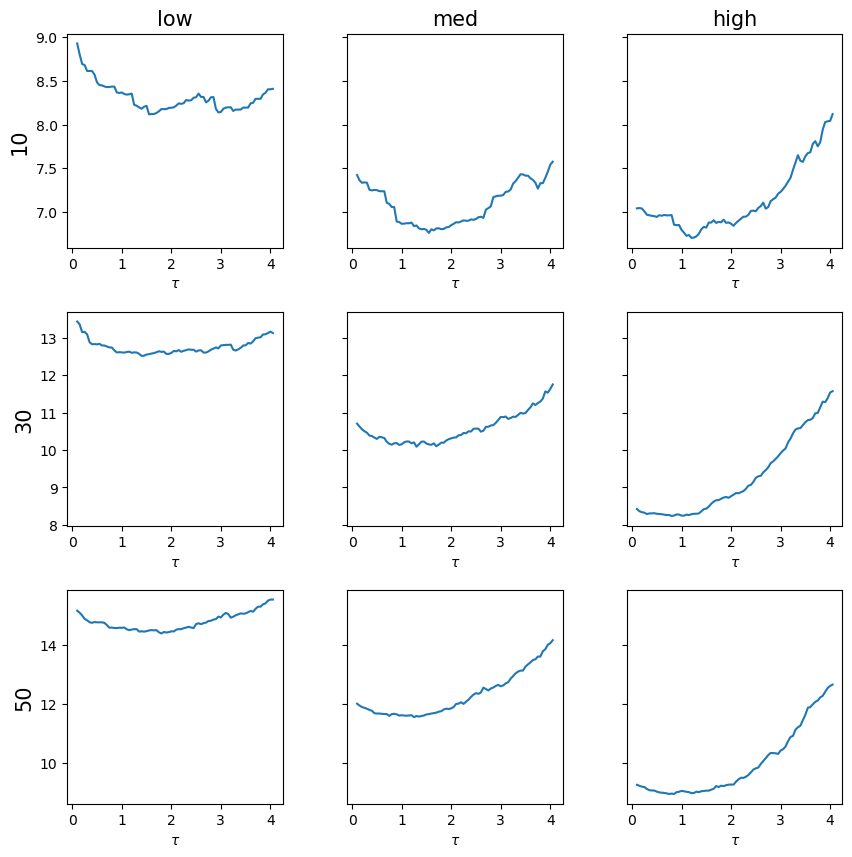

In [117]:
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(nrows=math.ceil(len(threshold_train_scores) / 3), ncols=3, hspace=0.3, wspace=0.3)
axes = gs.subplots(sharey='row')
for ax, train_scores in zip(axes.T.flatten(), theshold_train_scores):
    ax.plot(taus, train_scores)
    ax.set(xlabel='$\\tau$')

for ax, label in zip(axes[:, 0], ['10', '30', '50']):
    ax.set_ylabel(label, size=15)
for ax, label in zip(axes[0, :], ['low', 'med', 'high']):
    ax.set_title(label, size=15)
plt.savefig(f'tau_fit.pdf')

### Neural heuristic fit

Plot the loss during training.

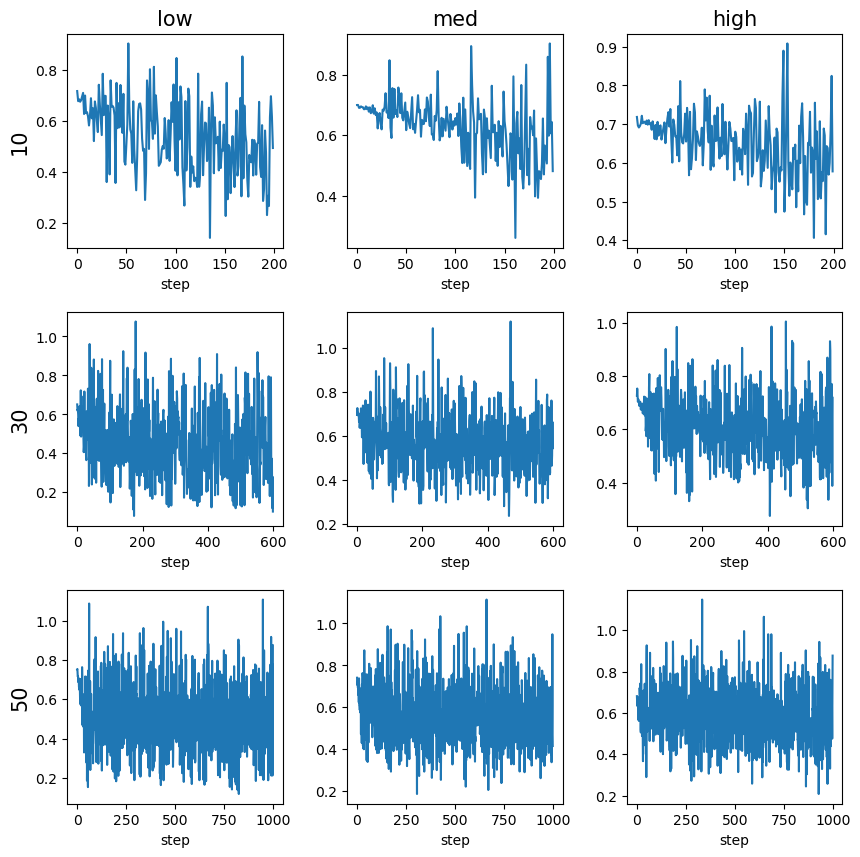

In [138]:
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(nrows=math.ceil(len(neural_losses) / 3), ncols=3, hspace=0.3, wspace=0.3)
axes = gs.subplots()
for ax, losses in zip(axes.T.flatten(), neural_losses):
    ax.plot(losses)
    ax.set(xlabel='step')

for ax, label in zip(axes[:, 0], ['10', '30', '50']):
    ax.set_ylabel(label, size=15)
for ax, label in zip(axes[0, :], ['low', 'med', 'high']):
    ax.set_title(label, size=15)

plt.savefig(f'neural_fit.pdf')

### Report and export

Transform total crossing time to average delay per vehicle (so we divide by the "size" of the instance).

In [49]:
for col in ['threshold_obj', 'neural_obj', 'opt_obj']:
    data[col] = data.apply(lambda row: (row[col] - average_release(test[row.name])) / (row['n_vehicles'] * 2), axis=1)

In [50]:
data

,n_vehicles,set_name,threshold_obj,threshold_train_time,neural_obj,neural_train_time,opt_obj
set_id,,,,,,,
0,10,low,9.678649,0.325938,30.409702,0.857920,4.660592
1,30,low,13.443424,1.749498,89.361939,2.592857,8.824522
2,50,low,11.909475,4.269822,167.287297,4.353840,8.195081
3,10,med,5.372980,0.322305,15.319813,0.845825,3.184564
4,30,med,11.513467,1.798540,97.181877,2.639786,8.396684
5,50,med,11.220314,4.298266,155.290134,4.355501,11.604158
6,10,high,5.423813,0.326130,14.279002,0.888417,3.952459
7,30,high,9.376740,1.769119,96.294489,2.618748,7.492145
8,50,high,8.825839,4.264454,155.099449,4.417252,7.038259


Save the results to `results.csv` to produce tables in the report.

In [51]:
data = data.drop('gen_id', axis=1, errors='ignore')
data.round(2).to_csv('../report/data-comparison/results.csv', index=False)